# Titanic baseline solution on Julia

In [26]:
# Install required packages
using Pkg

Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("ScikitLearn")
Pkg.add("DecisionTree")
Pkg.add("JLD2")

   Resolving package versions...
  No Changes to `~/Projects/julia/Project.toml`
  No Changes to `~/Projects/julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/julia/Project.toml`
  No Changes to `~/Projects/julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/julia/Project.toml`
  No Changes to `~/Projects/julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/julia/Project.toml`
  No Changes to `~/Projects/julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/julia/Project.toml`
  No Changes to `~/Projects/julia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Projects/julia/Project.toml`
  No Changes to `~/Projects/julia/Manifest.toml`


In [27]:
# Load required modules
using CSV, DataFrames, Plots, ScikitLearn, DecisionTree, JLD2

In [28]:
# Load training dataset and show summary info
train_df = CSV.read("train.csv",DataFrame)

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64?,Int64,Int64,String31,Float64,String15?,String1?
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S
6,6,0,3,"Moran, Mr. James",male,missing,0,0,330877,8.4583,missing,Q
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,missing,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,missing,S


In [29]:
describe(train_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,PassengerId,446.0,1,446.0,891,0,Int64
2,Survived,0.383838,0,0.0,1,0,Int64
3,Pclass,2.30864,1,3.0,3,0,Int64
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon",0,String
5,Sex,,female,,male,0,String7
6,Age,29.6991,0.42,28.0,80.0,177,"Union{Missing, Float64}"
7,SibSp,0.523008,0,0.0,8,0,Int64
8,Parch,0.381594,0,0.0,6,0,Int64
9,Ticket,,110152,,WE/P 5735,0,String31


In [30]:
# Process columns with missing values

# Remove rows with missing Embarked because it's just two rows
dropmissing!(train_df,"Embarked")

# Fill missing Age with median age which is 28
train_df.Age = replace(train_df.Age,missing=>28)

# 'Cabin' column has too many missing values (more than 50%), 
# so perhaps better to remove it at all
train_df = select(train_df,Not(["Cabin"]))

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
,Int64,Int64,Int64,String,String7,Float64,Int64,Int64,String31,Float64,String1
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,S
6,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,Q
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S


In [31]:
# Process categorial columns

# Group by Embarked columns to see which categories it has
# and number of rows in each category
embarked_group = groupby(train_df,"Embarked")
combine(embarked_group, nrow=>"Count")

Row,Embarked,Count
,String1,Int64
1,S,644
2,C,168
3,Q,77


In [32]:
# Encode and convert possible categories to numbers
train_df.Embarked = Int64.(replace(train_df.Embarked, "S" => 1, "C" => 2, "Q" => 3))

889-element Vector{Int64}:
 1
 2
 1
 1
 1
 3
 1
 1
 1
 2
 1
 1
 1
 ⋮
 2
 1
 1
 1
 1
 1
 3
 1
 1
 1
 2
 3

In [33]:
# The same with Sex column
combine(groupby(train_df,"Sex"), nrow=>"Count")

Row,Sex,Count
,String7,Int64
1,male,577
2,female,312


In [34]:
train_df.Sex = Int64.(replace(train_df.Sex, "female" => 1, "male" => 2))

889-element Vector{Int64}:
 2
 1
 1
 1
 2
 2
 2
 2
 1
 1
 1
 1
 2
 ⋮
 1
 1
 2
 1
 2
 2
 1
 2
 1
 1
 2
 2

In [35]:
# Lets see the same for Ticket column
combine(groupby(train_df,"Ticket"), nrow=>"Count")

Row,Ticket,Count
,String31,Int64
1,A/5 21171,1
2,PC 17599,1
3,STON/O2. 3101282,1
4,113803,2
5,373450,1
6,330877,1
7,17463,1
8,349909,4
9,347742,3


In [36]:
# As it has too much categories, perhaps it's not a good idea
# to think that they can be helpful to classify the data without,
# additional preprocessing. So, just remove it
train_df = select(train_df,Not(["Ticket"]))

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
,Int64,Int64,Int64,String,Int64,Float64,Int64,Int64,Float64,Int64
1,1,0,3,"Braund, Mr. Owen Harris",2,22.0,1,0,7.25,1
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38.0,1,0,71.2833,2
3,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.925,1
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1,1
5,5,0,3,"Allen, Mr. William Henry",2,35.0,0,0,8.05,1
6,6,0,3,"Moran, Mr. James",2,28.0,0,0,8.4583,3
7,7,0,1,"McCarthy, Mr. Timothy J",2,54.0,0,0,51.8625,1
8,8,0,3,"Palsson, Master. Gosta Leonard",2,2.0,3,1,21.075,1
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,11.1333,1


In [37]:
# The 'Name' and 'PassengerId' columns also not a good options to classify data,
# so remove them as well
train_df = select(train_df,Not(["Name", "PassengerId"]))

Row,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Int64
1,0,3,2,22.0,1,0,7.25,1
2,1,1,1,38.0,1,0,71.2833,2
3,1,3,1,26.0,0,0,7.925,1
4,1,1,1,35.0,1,0,53.1,1
5,0,3,2,35.0,0,0,8.05,1
6,0,3,2,28.0,0,0,8.4583,3
7,0,1,2,54.0,0,0,51.8625,1
8,0,3,2,2.0,3,1,21.075,1
9,1,3,1,27.0,0,2,11.1333,1


In [38]:
# Look at train data summary again to ensure that
# it's ready for training (no missing values, all columns are numeric)
describe(train_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Survived,0.382452,0,0.0,1,0,Int64
2,Pclass,2.31159,1,3.0,3,0,Int64
3,Sex,1.64904,1,2.0,2,0,Int64
4,Age,29.3152,0.42,28.0,80.0,0,Float64
5,SibSp,0.524184,0,0.0,8,0,Int64
6,Parch,0.382452,0,0.0,6,0,Int64
7,Fare,32.0967,0.0,14.4542,512.329,0,Float64
8,Embarked,1.3622,1,1.0,3,0,Int64


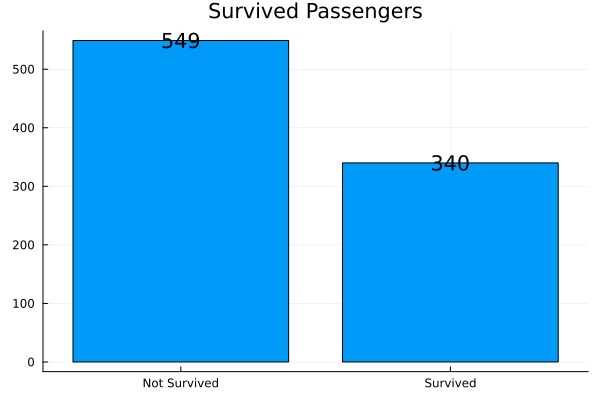

In [39]:
# Let's draw some plots that can show some patterns in data related
# to passengers survival which can help us later when verify how the machine learning works

survived = combine(groupby(train_df,"Survived"), nrow => "Count")
plot(survived.Survived, survived.Count, title="Survived Passengers", label=nothing, seriestype="bar", texts=survived.Count)
xticks!([0:1:1;],["Not Survived","Survived"])

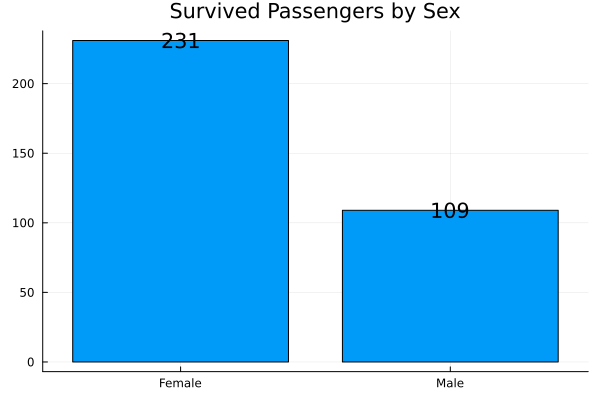

In [40]:
survived_by_sex = combine(groupby(train_df[train_df.Survived .== 1,:],"Sex"), nrow => "Count")
plot(survived_by_sex.Sex, survived_by_sex.Count, title="Survived Passengers by Sex", label=nothing, 
    seriestype="bar", texts=survived_by_sex.Count)
xticks!([1:1:2;],["Female","Male"])

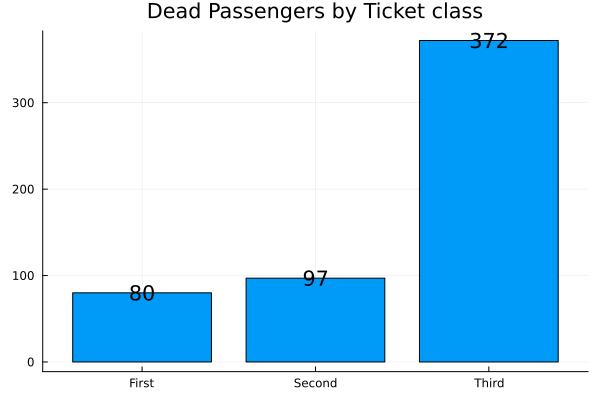

In [41]:
death_by_pclass = combine(groupby(train_df[train_df.Survived .== 0,:],"Pclass"), nrow => "Count")
plot(death_by_pclass.Pclass, death_by_pclass.Count, title="Dead Passengers by Ticket class", label=nothing, 
    seriestype="bar", texts=death_by_pclass.Count)
xticks!([1:1:3;],["First","Second","Third"])

In [42]:
# Extract features matrix and labels vector
X = Matrix(train_df[:,Not(["Survived"])])
y = train_df[:,"Survived"]

889-element Vector{Int64}:
 0
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 1
 0
 ⋮
 1
 1
 0
 0
 0
 0
 0
 0
 1
 0
 1
 0

In [50]:
using DecisionTree,ScikitLearn.CrossValidation
model = RandomForestClassifier(n_trees=100)
fit!(model,X,y)
accuracy = minimum(cross_val_score(model, X, y, cv=5))

0.7921348314606742

In [51]:
# Load testing dataset and show summary info
test_df = CSV.read("test.csv",DataFrame)
describe(test_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,PassengerId,1100.5,892,1100.5,1309,0,Int64
2,Pclass,2.26555,1,3.0,3,0,Int64
3,Name,,"Abbott, Master. Eugene Joseph",,"van Billiard, Master. Walter John",0,String
4,Sex,,female,,male,0,String7
5,Age,30.2726,0.17,27.0,76.0,86,"Union{Missing, Float64}"
6,SibSp,0.447368,0,0.0,8,0,Int64
7,Parch,0.392344,0,0.0,9,0,Int64
8,Ticket,,110469,,W.E.P. 5734,0,String31
9,Fare,35.6272,0.0,14.4542,512.329,1,"Union{Missing, Float64}"


In [52]:
# Save PassengerId field to separate variable
PassengerId = test_df[:,"PassengerId"]

418-element Vector{Int64}:
  892
  893
  894
  895
  896
  897
  898
  899
  900
  901
  902
  903
  904
    ⋮
 1298
 1299
 1300
 1301
 1302
 1303
 1304
 1305
 1306
 1307
 1308
 1309

In [53]:
# Repeat the same transformations as we done for training dataset
test_df = select(test_df,Not(["PassengerId","Name","Ticket","Cabin"]))
test_df.Age = replace(test_df.Age,missing=>28)
test_df.Embarked = replace(test_df.Embarked,"S" => 1, "C" => 2, "Q" => 3)
test_df.Embarked = convert.(Int64,test_df.Embarked)
test_df.Sex = replace(test_df.Sex,"female" => 1,"male" => 2)
test_df.Sex = convert.(Int64,test_df.Sex)

# In addition, replace missing value in 'Fare' field with median
test_df.Fare = replace(test_df.Fare,missing=>14.4542)

418-element Vector{Float64}:
   7.8292
   7.0
   9.6875
   8.6625
  12.2875
   9.225
   7.6292
  29.0
   7.2292
  24.15
   7.8958
  26.0
  82.2667
   ⋮
  10.5
 211.5
   7.7208
  13.775
   7.75
  90.0
   7.775
   8.05
 108.9
   7.25
   8.05
  22.3583

In [54]:
# Ensure that all data transofrmations applied correctly
describe(test_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Pclass,2.26555,1,3.0,3,0,Int64
2,Sex,1.63636,1,2.0,2,0,Int64
3,Age,29.805,0.17,28.0,76.0,0,Float64
4,SibSp,0.447368,0,0.0,8,0,Int64
5,Parch,0.392344,0,0.0,9,0,Int64
6,Fare,35.5765,0.0,14.4542,512.329,0,Float64
7,Embarked,1.46411,1,1.0,3,0,Int64


In [55]:
# Make a prediction for testing dataframe using the trained model
Survived = predict(model,Matrix(test_df))

418-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 1
 ⋮
 0
 0
 1
 1
 1
 1
 0
 0
 1
 0
 0
 0

In [56]:
# Create a dataset in a format, required for Kaggle submission (with 'PassengerId' and 'Survived' columns)
# and save it to CSV
submit_df = DataFrame(PassengerId=PassengerId,Survived=Survived)
CSV.write("submission.csv",submit_df)

"submission.csv"

In [57]:
submit_df

Row,PassengerId,Survived
,Int64,Int64
1,892,0
2,893,0
3,894,0
4,895,0
5,896,0
6,897,0
7,898,0
8,899,0
9,900,1


In [58]:
# Serialize and save the model to a file for deployment in production
save_object("titanic.jld2",model)